In [4]:
# the aim is to create pickles for the features in this database so i can avoid loading it all the time and streamline the process a bit.

# get data:

import sys
sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Applications/PyCharm.app/Contents/plugins/python/helpers-pro/jupyter_debug', '/Applications/PyCharm.app/Contents/plugins/python/helpers/pydev', '/Users/david/Documents/mastersCode/ubm/data/pitch_tracking_database', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm']


In [7]:
# test for gmm-ubm on whale calls
from importlib import reload
import audio_datastore.audio_datastore as myads
reload(myads)
from collections import Counter
import numpy as np
import config
import librosa
import utils as my_utils
import feature_extraction.fe_spafe.fe_spafe as fe_spafe
import feature_extraction.fe_base as fe_base
import os.path
reload(fe_base)
reload(fe_spafe)

<module 'feature_extraction.fe_spafe.fe_spafe' from '/Users/david/Documents/mastersCode/ubm/feature_extraction/fe_spafe/fe_spafe.py'>

In [8]:
# create ads

# female ads
datasetFolder = r"/Users/david/Documents/data/speech/ivectors/SPEECH DATA/FEMALE/MIC"
female_ads = myads.AudioDatastore()
female_ads.populate(datasetFolder, include_sub_folders=True, label_source=True)
Counter(female_ads.labels).values()
# male ads
datasetFolder = r"/Users/david/Documents/data/speech/ivectors/SPEECH DATA/MALE/MIC"
male_ads = myads.AudioDatastore()
male_ads.populate(datasetFolder, include_sub_folders=True, label_source=True)
Counter(male_ads.labels).values()
# combine ads
ads = myads.AudioDatastore()
ads.set([datasetFolder], files=female_ads.files + male_ads.files, labels=female_ads.labels + male_ads.labels)
# split ads
all_labels = ["M01", "M02", "M03", "M04", "M06", "M07", "M08", "M09", "F01", "F02", "F03", "F04", "F06", "F07",
                     "F08", "F09", "M05", "M10", "F05", "F10"]

ads_all = myads.subset(ads, all_labels)

In [9]:
from collections import Counter
print(Counter(ads_all.labels).keys()) # equals to list(set(words))
print(Counter(ads_all.labels).values()) # counts the elements' frequency

dict_keys(['F10', 'F03', 'F04', 'F05', 'F02', 'F07', 'F09', 'F08', 'F01', 'F06', 'M07', 'M09', 'M08', 'M06', 'M01', 'M04', 'M03', 'M02', 'M05', 'M10'])
dict_values([236, 236, 236, 236, 236, 236, 236, 234, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236])


In [10]:
# VAD
import torch
torch.set_num_threads(1)
model, torch_utils = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                              model='silero_vad',
                              force_reload=True)
(get_speech_timestamps,
 _, read_audio,
 *_) = torch_utils

Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /Users/david/.cache/torch/hub/master.zip


In [34]:
# fe methods

from feature_extraction.fe_configs import NormFactor
from spafe.features.mfcc import *

def get_mfcc(sign):
        features = mfcc(sig=sign, fs=config.SAMPLING_RATE, num_ceps=config.N_MFCC, nfft=config.N_FFT)
        features = zero_handling(features)
        return features

def get_log_mel(sign):
        features, _ = mel_spectrogram(sig=sign, fs=config.SAMPLING_RATE, nfft=config.N_FFT)
        features = zero_handling(features)
        log_features = np.log(features)
        return log_features

def get_delta_mfccs(sign):
        features = get_mfcc(sign)
        delta_features = librosa.feature.delta(features.T, order=1).T
        features_comb = np.concatenate([features, delta_features], axis=1)
        return features_comb


In [26]:
# processing

import processing.process_method_base as process_method_base
reload(process_method_base)

process_method = process_method_base.ProcessMethodBase(snr_db=None, reverb=False, model=model, get_speech_timestamps=get_speech_timestamps)
process_method.post_process()

In [36]:
# quick test
import matplotlib.pyplot as plt
import spafe.utils.vis as vis

test_file = ads.files[0]
test_processed = process_method.pre_process(test_file)
test_mfcc_feat = get_delta_mfccs(test_processed)

# plt.plot(test_processed)
# vis.show_features(test_mfcc_feat,'','','')

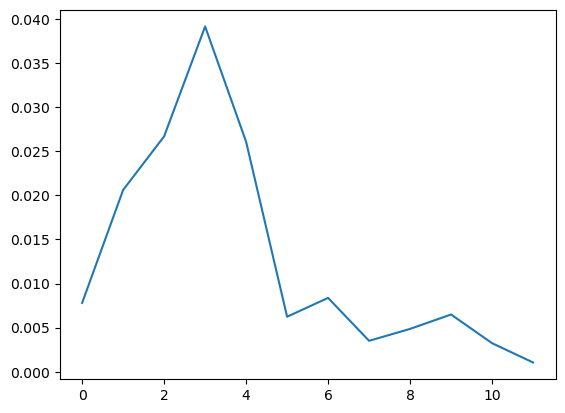

tensor(19.6237)

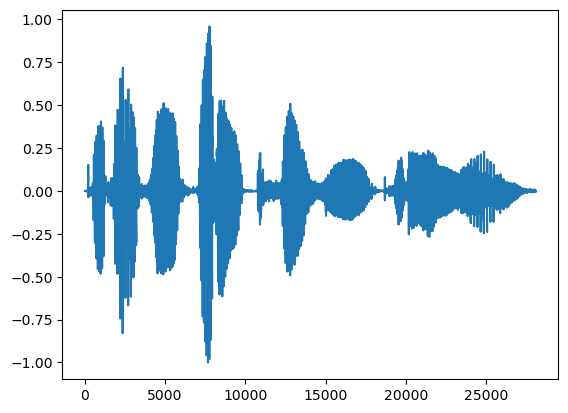

In [42]:
# noise addition

ap = my_utils.periodic_power(test_processed, 5000, 2500)
plt.plot(ap)
plt.show()
plt.plot(test_processed)
np.mean(ap)

# test_processed_torch = torch.from_numpy(test_processed[np.newaxis, ...])
# test_processed_torch.norm(p=2)

In [52]:
# feature extraction and saving

from audio_datastore.audio_datastore import subset

speakers = np.unique(ads_all.labels)

all_features = []
for i in range(len(speakers)):
    ads_train_subset = subset(ads_all, speakers[i])
    speaker_features = []
    print('getting features for speaker: ', speakers[i])
    for file in ads_train_subset.files:
        signal = process_method.pre_process(file)
        speaker_features.append(get_mfcc(signal))
    all_features.append(speaker_features)

# means = []
# std = []
# for feature in all_features:
#     means.append(np.mean(feature, axis=0))
#     std.append(np.std(feature, axis=0))
#
# means = np.array(means)
# means = np.mean(means, axis=0)
#
# std = np.array(std)
# std = np.mean(std, axis=0)
#
# norm_factor = NormFactor(means, std)

getting features for speaker:  F01
getting features for speaker:  F02
getting features for speaker:  F03
getting features for speaker:  F04
getting features for speaker:  F05
getting features for speaker:  F06
getting features for speaker:  F07
getting features for speaker:  F08
getting features for speaker:  F09
getting features for speaker:  F10
getting features for speaker:  M01
getting features for speaker:  M02
getting features for speaker:  M03
getting features for speaker:  M04
getting features for speaker:  M05
getting features for speaker:  M06
getting features for speaker:  M07
getting features for speaker:  M08
getting features for speaker:  M09
getting features for speaker:  M10


In [53]:
# update adas
# adsEnroll.files =
all_features_cat = [item for sublist in all_features for item in sublist]


In [54]:
ads_all_v2 = myads.get_deep_copy(ads_all)

In [55]:
ads_all_v2.files = all_features_cat

In [2]:
import pickle
# pickle.dump(ads_all_v2, open('adsAll.pickle','wb'))

# adsEnrollSaved = pickle.load(open('adsEnroll.pickle','rb'))

In [57]:
# create object with normal stats on as well

means = []
std = []
for feature in all_features_cat:
    means.append(np.mean(feature, axis=0))
    std.append(np.std(feature, axis=0))

means = np.array(means)
means = np.mean(means, axis=0)

std = np.array(std)
std = np.mean(std, axis=0)

norm_factor = NormFactor(means, std)
norm_factor

In [60]:
ads_all_v2.features = True

In [61]:
mfcc_feats = {
    ads: ads_all_v2,
    norm_factor: norm_factor
}

In [65]:
pickle.dump(mfcc_feats, open('ads_pitch_tracking_db_mfcc.pickle','wb'))

In [6]:
whts_happening = pickle.load(open('ads_pitch_tracking_db_mfcc.pickle','rb'))

In [46]:
import torchaudio

path = "save_example_default.wav"

waveform = torch.from_numpy(all_features_cat[0][np.newaxis, ...])
sample_rate = config.SAMPLE_RATE
torchaudio.save(path, waveform, sample_rate)
# inspect_file(path)